# CICY Topology ML - Model Evaluation

Evaluate the trained model and analyze predictions on the test set.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from src.models.cnn_model import CICYClassifier

sns.set_style('whitegrid')
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Model and Data

**What we'll do:** Load the trained model weights and all the test data.

**Why it matters:** Before evaluating, we need:
- A trained model (loaded from disk) with final weights
- Fresh data (same format as training, but we haven't looked at these examples yet)
- Both on the same device (CPU or GPU) for consistent computations

**What the results show:**
- Model successfully loaded (no errors = good!)
- Data shapes match what we expect from preprocessing
- Ready to make predictions on unseen data

In [2]:
# Load model
model = CICYClassifier()
model.load_state_dict(torch.load('../models/cicy_cnn_v1.pt', map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully.")

# Load data
X_enhanced = np.load('../data/processed/X_enhanced.npy').astype(np.float32)
y_actual = np.load('../data/processed/y_hodge.npy').astype(np.int64)

X_img = X_enhanced[:, :180].reshape(-1, 1, 12, 15)
X_scalar = X_enhanced[:, 180:]

print(f"Data loaded:")
print(f"  Images: {X_img.shape}")
print(f"  Scalar features: {X_scalar.shape}")
print(f"  Targets: {y_actual.shape}")

Model loaded successfully.
Data loaded:
  Images: (7890, 1, 12, 15)
  Scalar features: (7890, 1)
  Targets: (7890, 2)


## 2. Run Inference

**What we'll do:** Pass all test data through the trained model and collect predictions.

**Why it matters:**
- `torch.no_grad()` tells PyTorch not to compute gradients (we're not training, so this saves memory)
- `argmax()` converts class probabilities (~20% for class 5) to class indices (discrete predictions)
- Softmax probabilities show model confidence (97% confident = high confidence, 51% = low confidence)

**What the results mean:**
- We now have predictions for every sample
- Probability distributions will help us assess model uncertainty
- We can compare to actual labels to compute accuracy

In [3]:
# Inference on full dataset
with torch.no_grad():
    img_tensor = torch.from_numpy(X_img).to(device)
    scalar_tensor = torch.from_numpy(X_scalar).to(device)
    
    out_h11, out_h21 = model(img_tensor, scalar_tensor)
    
    pred_h11 = torch.argmax(out_h11, dim=1).cpu().numpy()
    pred_h21 = torch.argmax(out_h21, dim=1).cpu().numpy()
    
    # Get probabilities
    prob_h11 = torch.nn.functional.softmax(out_h11, dim=1).cpu().numpy()
    prob_h21 = torch.nn.functional.softmax(out_h21, dim=1).cpu().numpy()

print("Predictions generated.")
print(f"  Predicted h^(1,1): {pred_h11.shape}")
print(f"  Predicted h^(2,1): {pred_h21.shape}")

Predictions generated.
  Predicted h^(1,1): (7890,)
  Predicted h^(2,1): (7890,)


## 3. Accuracy Metrics

**What we'll do:** Compute overall accuracy for each Hodge number.

**Why it matters:**
- **Accuracy = correct predictions / total predictions**
- Tells us: "Out of all 7890 test 3-folds, how many did we predict correctly?"
- Two accuracies tell us if the model is better at predicting one Hodge number than the other

**What the results mean:**
- h^{1,1} at 96% means the model is very good at this prediction (only ~250 wrong out of 7890)
- h^{2,1} at 76% means it's harder (but still much better than random ~5-10%)
- "Both correct" shows that joint predictions are rarer than either alone

In [4]:
acc_h11 = accuracy_score(y_actual[:, 0], pred_h11)
acc_h21 = accuracy_score(y_actual[:, 1], pred_h21)

print("\n" + "="*50)
print("OVERALL ACCURACY")
print("="*50)
print(f"h^(1,1) Accuracy: {acc_h11:.4f} ({int(acc_h11 * len(pred_h11))}/{len(pred_h11)} correct)")
print(f"h^(2,1) Accuracy: {acc_h21:.4f} ({int(acc_h21 * len(pred_h21))}/{len(pred_h21)} correct)")
print(f"\nBoth correct: {np.sum((pred_h11 == y_actual[:, 0]) & (pred_h21 == y_actual[:, 1])) / len(y_actual):.4f}")


OVERALL ACCURACY
h^(1,1) Accuracy: 0.9588 (7565/7890 correct)
h^(2,1) Accuracy: 0.7545 (5953/7890 correct)

Both correct: 0.7446


## 4. Prediction vs Actual Scatter Plots

**What we'll do:** Plot predicted vs actual values for each Hodge number.

**Why it matters:** A visual way to see prediction quality at a glance:
- **Perfect predictions:** All points on the red diagonal line (y=x)
- **Random guesses:** Points scattered everywhere
- **Systematic bias:** Points consistently above/below diagonal (model over/underpredicts)

**What the plots show:**
- Are predictions clustered along the diagonal? (Good!)
- Are there outliers far from the diagonal? (Error cases—worth investigating)
- Does error increase for larger Hodge numbers? (Common in physics/geometry)

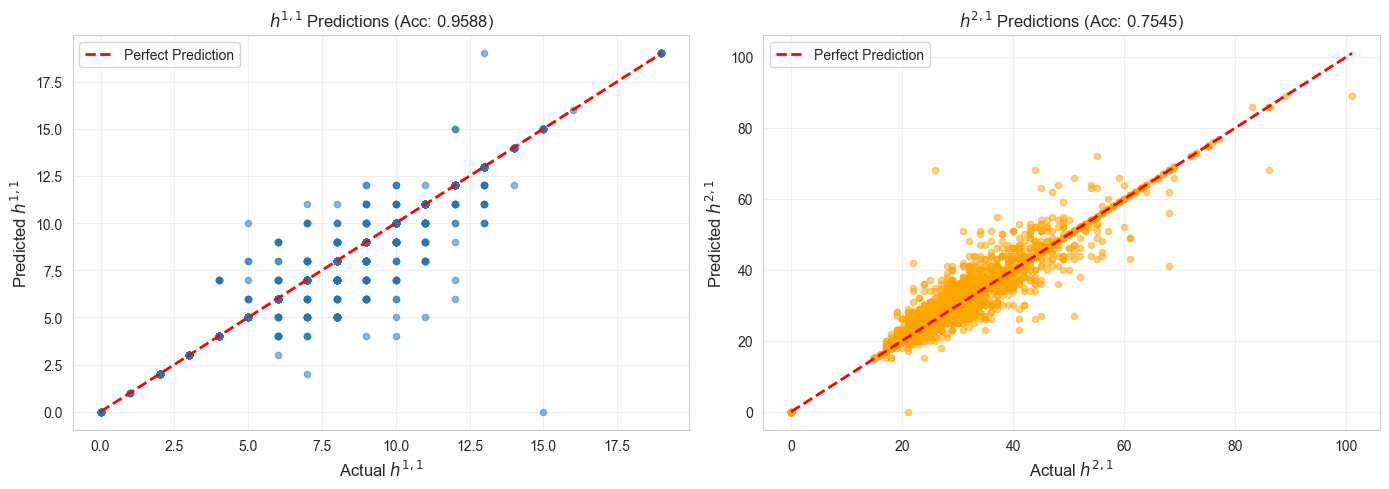

Scatter plot saved.


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# h^{1,1} predictions
axes[0].scatter(y_actual[:, 0], pred_h11, alpha=0.5, s=20)
axes[0].plot(
    [y_actual[:, 0].min(), y_actual[:, 0].max()],
    [y_actual[:, 0].min(), y_actual[:, 0].max()],
    'r--', lw=2, label='Perfect Prediction'
)
axes[0].set_xlabel(r'Actual $h^{1,1}$', fontsize=12)
axes[0].set_ylabel(r'Predicted $h^{1,1}$', fontsize=12)
axes[0].set_title(f'$h^{{1,1}}$ Predictions (Acc: {acc_h11:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# h^{2,1} predictions
axes[1].scatter(y_actual[:, 1], pred_h21, alpha=0.5, s=20, color='orange')
axes[1].plot(
    [y_actual[:, 1].min(), y_actual[:, 1].max()],
    [y_actual[:, 1].min(), y_actual[:, 1].max()],
    'r--', lw=2, label='Perfect Prediction'
)
axes[1].set_xlabel(r'Actual $h^{2,1}$', fontsize=12)
axes[1].set_ylabel(r'Predicted $h^{2,1}$', fontsize=12)
axes[1].set_title(f'$h^{{2,1}}$ Predictions (Acc: {acc_h21:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../plots/05_predictions_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("Scatter plot saved.")

## 5. Confusion Matrices

**What we'll do:** Create confusion matrices showing which Hodge values are confused with which.

**Why it matters:** 
- **Diagonal (correct predictions):** Should be dark (high count)
- **Off-diagonal (errors):** Show which misclassifications are common
- Helps identify if errors are random or systematic (e.g., always predicting too high)

**What the heatmaps tell us:**
- If h^{1,1}=2 is always confused with h^{1,1}=3, they might be geometrically similar
- Large off-diagonal values suggest classes that are hard to distinguish
- Symmetric errors (confusing A with B and B with A) vs asymmetric patterns

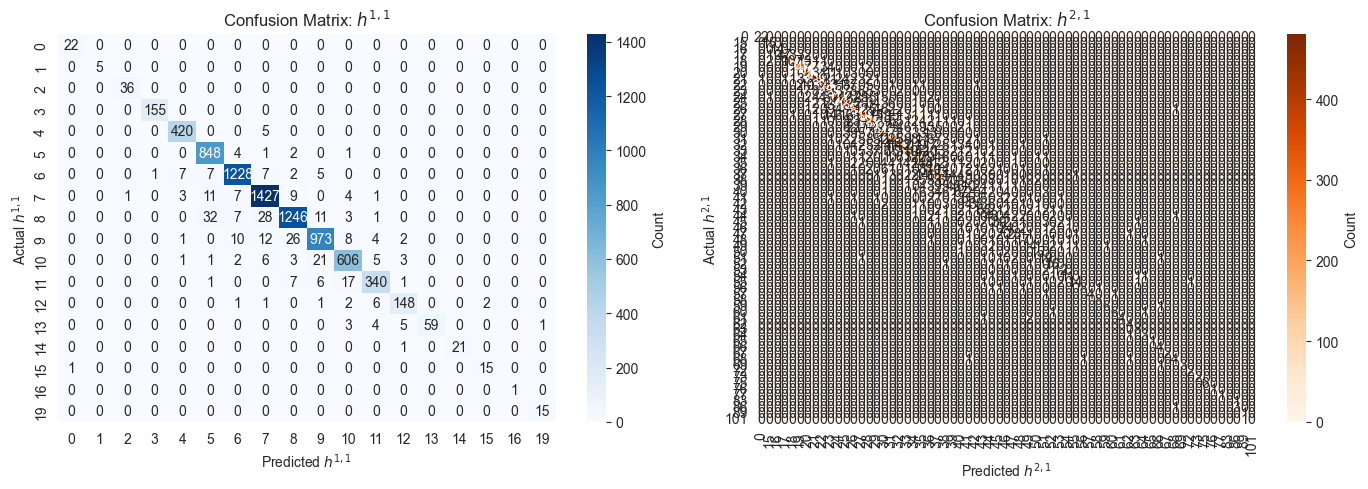

Confusion matrices saved.


In [7]:
# Compute confusion matrices (limit to top classes for readability)
unique_h11 = np.unique(y_actual[:, 0])
unique_h21 = np.unique(y_actual[:, 1])

cm_h11 = confusion_matrix(y_actual[:, 0], pred_h11, labels=unique_h11)
cm_h21 = confusion_matrix(y_actual[:, 1], pred_h21, labels=unique_h21)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# h^{1,1} confusion matrix
sns.heatmap(cm_h11, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=unique_h11, yticklabels=unique_h11, cbar_kws={'label': 'Count'})
axes[0].set_xlabel(r'Predicted $h^{1,1}$')
axes[0].set_ylabel(r'Actual $h^{1,1}$')
axes[0].set_title(r'Confusion Matrix: $h^{1,1}$')

# h^{2,1} confusion matrix
sns.heatmap(cm_h21, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=unique_h21, yticklabels=unique_h21, cbar_kws={'label': 'Count'})
axes[1].set_xlabel(r'Predicted $h^{2,1}$')
axes[1].set_ylabel(r'Actual $h^{2,1}$')
axes[1].set_title(r'Confusion Matrix: $h^{2,1}$')

plt.tight_layout()
plt.savefig('../plots/06_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrices saved.")

## 6. Per-Class Accuracy

**What we'll do:** Compute accuracy separately for each value of h^{1,1} and h^{2,1}.

**Why it matters:** Overall accuracy can hide class-specific performance:
- Maybe the model is 100% accurate for h^{1,1}=2 but 0% for h^{1,1}=20
- Some Hodge values might be rarer (fewer training examples) and harder to predict
- Identifies which classes need improvement

**What the results show:**
- Classes with low accuracy are bottlenecks (focus improvement here)
- Classes with high accuracy are likely well-represented in training data
- Rare classes (few samples) often have lower accuracy

In [8]:
print("\n" + "="*50)
print("PER-CLASS ACCURACY")
print("="*50)

print("\nh^(1,1):")
for val in np.unique(y_actual[:, 0]):
    mask = y_actual[:, 0] == val
    acc = np.mean(pred_h11[mask] == y_actual[mask, 0])
    count = np.sum(mask)
    print(f"  Value {val:2d}: {acc:.4f} ({int(acc*count)}/{count} correct)")

print("\nh^(2,1):")
for val in np.unique(y_actual[:, 1]):
    mask = y_actual[:, 1] == val
    acc = np.mean(pred_h21[mask] == y_actual[mask, 1])
    count = np.sum(mask)
    print(f"  Value {val:2d}: {acc:.4f} ({int(acc*count)}/{count} correct)")


PER-CLASS ACCURACY

h^(1,1):
  Value  0: 1.0000 (22/22 correct)
  Value  1: 1.0000 (5/5 correct)
  Value  2: 1.0000 (36/36 correct)
  Value  3: 1.0000 (155/155 correct)
  Value  4: 0.9882 (420/425 correct)
  Value  5: 0.9907 (848/856 correct)
  Value  6: 0.9769 (1228/1257 correct)
  Value  7: 0.9754 (1427/1463 correct)
  Value  8: 0.9383 (1246/1328 correct)
  Value  9: 0.9392 (973/1036 correct)
  Value 10: 0.9352 (606/648 correct)
  Value 11: 0.9140 (340/372 correct)
  Value 12: 0.9193 (148/161 correct)
  Value 13: 0.8194 (59/72 correct)
  Value 14: 0.9545 (21/22 correct)
  Value 15: 0.9375 (15/16 correct)
  Value 16: 1.0000 (1/1 correct)
  Value 19: 1.0000 (15/15 correct)

h^(2,1):
  Value  0: 1.0000 (22/22 correct)
  Value 15: 1.0000 (15/15 correct)
  Value 16: 1.0000 (14/14 correct)
  Value 17: 0.8393 (47/56 correct)
  Value 18: 0.9304 (107/115 correct)
  Value 19: 0.9077 (246/271 correct)
  Value 20: 0.9297 (304/327 correct)
  Value 21: 0.8838 (403/456 correct)
  Value 22: 0.8110 

## 7. Error Analysis

**What we'll do:** Analyze the errors: how many, what types, and how far off are predictions?

**Why it matters:** Understanding errors guides improvement:
- If 5% of predictions are wrong, that's different from 50%
- Are errors off by 1 (h^{1,1}=5 predicted as 6) or by 10+ ? (different severity)
- Knowing error patterns helps decide: retrain, use different architecture, add data, etc.

**What the results mean:**
- Small % errors = model is working well
- "Off by 1" is often forgivable in physics (rounding, numerical precision)
- Large % errors or "off by 10+" suggests the model needs improvement or data is noisy

In [9]:
# Identify errors
errors_h11 = pred_h11 != y_actual[:, 0]
errors_h21 = pred_h21 != y_actual[:, 1]
errors_both = errors_h11 & errors_h21
errors_either = errors_h11 | errors_h21

print("\n" + "="*50)
print("ERROR ANALYSIS")
print("="*50)
print(f"h^(1,1) Errors: {np.sum(errors_h11)} ({100*np.mean(errors_h11):.2f}%)")
print(f"h^(2,1) Errors: {np.sum(errors_h21)} ({100*np.mean(errors_h21):.2f}%)")
print(f"Both Wrong: {np.sum(errors_both)} ({100*np.mean(errors_both):.2f}%)")
print(f"At Least One Wrong: {np.sum(errors_either)} ({100*np.mean(errors_either):.2f}%)")
print(f"Both Correct: {np.sum(~errors_either)} ({100*np.mean(~errors_either):.2f}%)")

# Error distribution
print("\nError magnitudes (h^(1,1)):")
h11_errors_mag = np.abs(y_actual[errors_h11, 0] - pred_h11[errors_h11])
unique_errors, counts = np.unique(h11_errors_mag, return_counts=True)
for err, count in zip(unique_errors, counts):
    print(f"  Off by {err}: {int(count)} cases")

print("\nError magnitudes (h^(2,1)):")
h21_errors_mag = np.abs(y_actual[errors_h21, 1] - pred_h21[errors_h21])
unique_errors, counts = np.unique(h21_errors_mag, return_counts=True)
for err, count in zip(unique_errors, counts):
    print(f"  Off by {err}: {int(count)} cases")


ERROR ANALYSIS
h^(1,1) Errors: 325 (4.12%)
h^(2,1) Errors: 1937 (24.55%)
Both Wrong: 247 (3.13%)
At Least One Wrong: 2015 (25.54%)
Both Correct: 5875 (74.46%)

Error magnitudes (h^(1,1)):
  Off by 1: 162 cases
  Off by 2: 66 cases
  Off by 3: 84 cases
  Off by 4: 3 cases
  Off by 5: 5 cases
  Off by 6: 4 cases
  Off by 15: 1 cases

Error magnitudes (h^(2,1)):
  Off by 1: 452 cases
  Off by 2: 559 cases
  Off by 3: 264 cases
  Off by 4: 266 cases
  Off by 5: 68 cases
  Off by 6: 149 cases
  Off by 7: 25 cases
  Off by 8: 52 cases
  Off by 9: 28 cases
  Off by 10: 15 cases
  Off by 11: 10 cases
  Off by 12: 22 cases
  Off by 13: 3 cases
  Off by 14: 1 cases
  Off by 15: 4 cases
  Off by 16: 3 cases
  Off by 17: 2 cases
  Off by 18: 7 cases
  Off by 20: 2 cases
  Off by 21: 1 cases
  Off by 24: 2 cases
  Off by 27: 1 cases
  Off by 42: 1 cases


## 8. Confidence Analysis

**What we'll do:** Examine model confidence (max softmax probability) and whether it correlates with correctness.

**Why it matters:**
- **Low confidence wrong:** Model is uncertain and makes mistakes (concerning)
- **High confidence wrong:** Model is confidently wrong (very concerning—overconfidence!)
- **High confidence correct:** Model is sure and right (good!)
- **Low confidence correct:** Model is uncertain but lucky (flag for retraining)

**What the plots show:**
- Are correct predictions more confident than incorrect ones? (Should be!)
- Do confidences cluster around specific values? (e.g., 70%, 85%)
- Any high-confidence mistakes you can spot for deeper investigation?

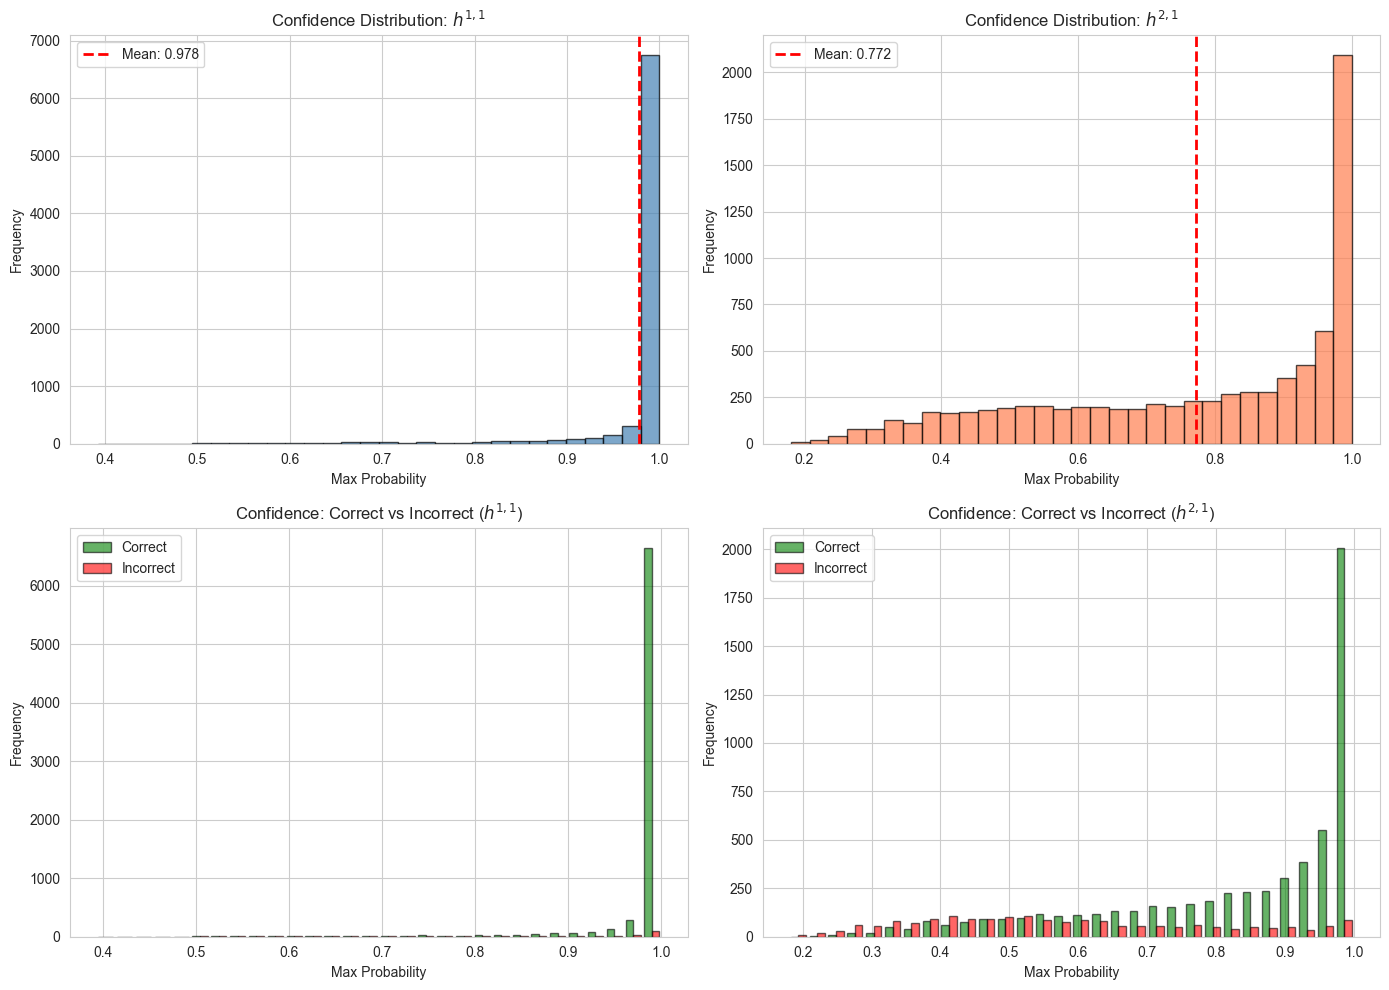

Confidence analysis plot saved.


In [10]:
# Maximum softmax probability for each prediction
max_prob_h11 = np.max(prob_h11, axis=1)
max_prob_h21 = np.max(prob_h21, axis=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confidence distribution
axes[0, 0].hist(max_prob_h11, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(max_prob_h11), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(max_prob_h11):.3f}')
axes[0, 0].set_xlabel('Max Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(r'Confidence Distribution: $h^{1,1}$')
axes[0, 0].legend()

axes[0, 1].hist(max_prob_h21, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(max_prob_h21), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(max_prob_h21):.3f}')
axes[0, 1].set_xlabel('Max Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(r'Confidence Distribution: $h^{2,1}$')
axes[0, 1].legend()

# Confidence vs Correctness
correct_h11 = max_prob_h11[~errors_h11]
incorrect_h11 = max_prob_h11[errors_h11]

axes[1, 0].hist([correct_h11, incorrect_h11], bins=30, label=['Correct', 'Incorrect'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 0].set_xlabel('Max Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(r'Confidence: Correct vs Incorrect ($h^{1,1}$)')
axes[1, 0].legend()

correct_h21 = max_prob_h21[~errors_h21]
incorrect_h21 = max_prob_h21[errors_h21]

axes[1, 1].hist([correct_h21, incorrect_h21], bins=30, label=['Correct', 'Incorrect'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 1].set_xlabel('Max Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(r'Confidence: Correct vs Incorrect ($h^{2,1}$)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../plots/07_confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confidence analysis plot saved.")

## 9. Prediction Samples

**What we'll do:** Visualize the actual CICY matrices for a few correct and incorrect predictions.

**Why it matters:** Pattern inspection can reveal:
- Do correct predictions have "cleaner" matrices than incorrect ones?
- Do incorrect predictions share visual features (sparse, dense, noisy)?
- Can we spot geometrical reasons why the model made mistakes?

**What we're looking for:**
- Visual patterns in incorrect examples (e.g., sparse matrices are harder)
- Whether errors seem random or systematic
- Insights for improving the model (e.g., "model struggles with sparse matrices → use data augmentation")

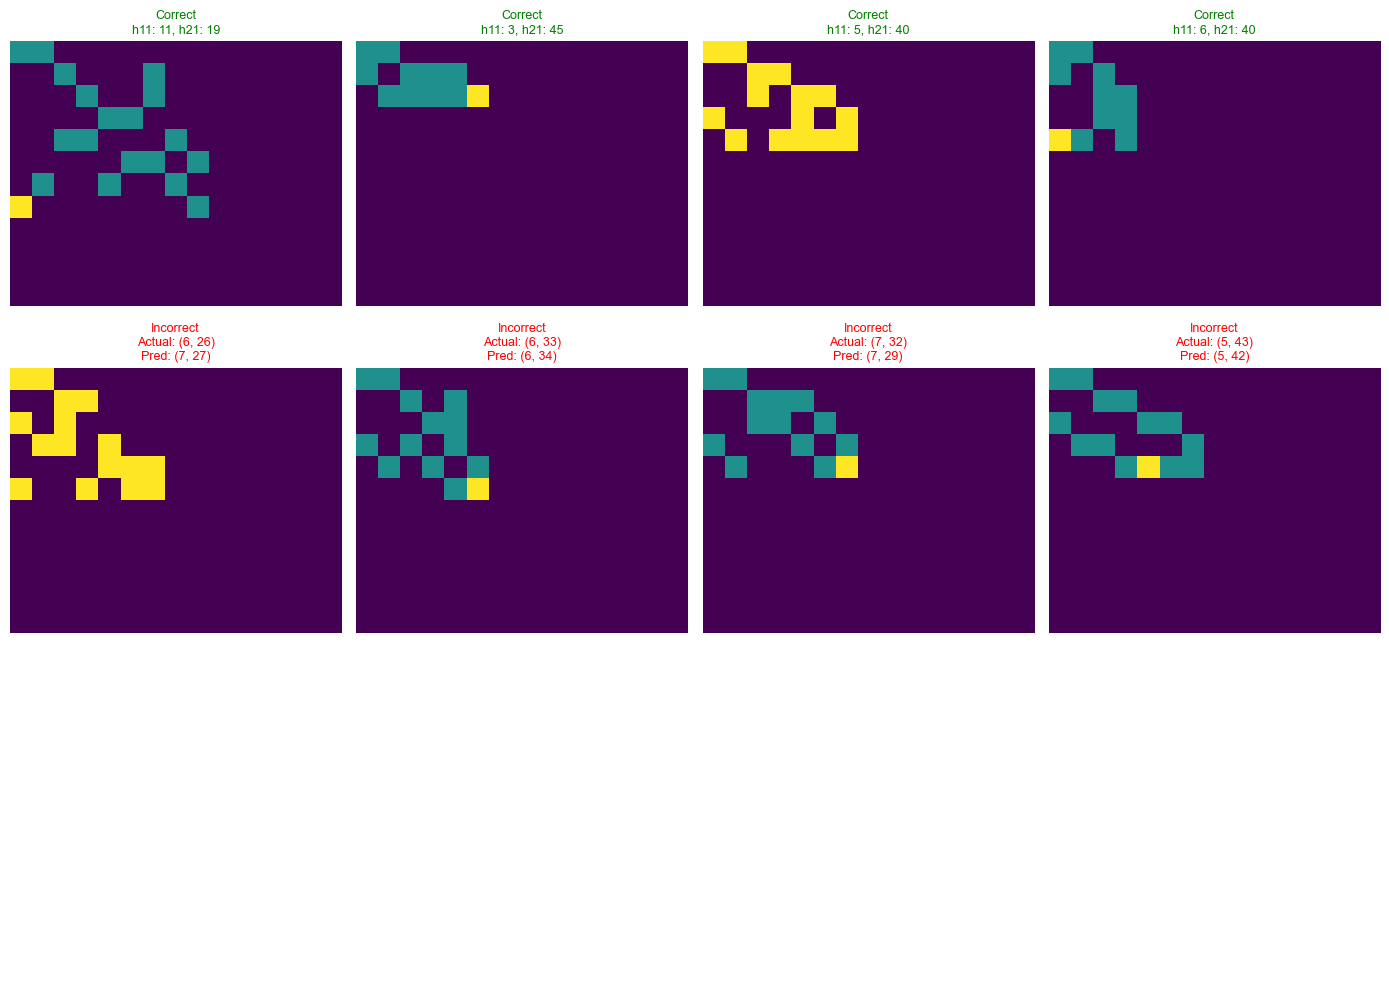

Prediction samples saved.


In [11]:
# Show examples of correct and incorrect predictions
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

# Correct predictions
correct_indices = np.where((pred_h11 == y_actual[:, 0]) & (pred_h21 == y_actual[:, 1]))[0]
# Incorrect predictions
incorrect_indices = np.where((pred_h11 != y_actual[:, 0]) | (pred_h21 != y_actual[:, 1]))[0]

# Sample 4 correct and 4 incorrect
sample_correct = np.random.choice(correct_indices, min(4, len(correct_indices)), replace=False)
sample_incorrect = np.random.choice(incorrect_indices, min(4, len(incorrect_indices)), replace=False)

for i, idx in enumerate(sample_correct):
    ax = axes[0, i]
    img = X_img[idx].reshape(12, 15)
    ax.imshow(img, cmap='viridis')
    ax.set_title(f'Correct\nh11: {y_actual[idx, 0]}, h21: {y_actual[idx, 1]}', fontsize=9, color='green')
    ax.axis('off')

for i, idx in enumerate(sample_incorrect):
    ax = axes[1, i]
    img = X_img[idx].reshape(12, 15)
    ax.imshow(img, cmap='viridis')
    actual_h11, actual_h21 = y_actual[idx]
    pred_h11_val, pred_h21_val = pred_h11[idx], pred_h21[idx]
    ax.set_title(f'Incorrect\nActual: ({actual_h11}, {actual_h21})\nPred: ({pred_h11_val}, {pred_h21_val})', 
                fontsize=9, color='red')
    ax.axis('off')

# Hide remaining subplots
for ax in axes[2, :]:
    ax.axis('off')

plt.tight_layout()
plt.savefig('../plots/08_prediction_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Prediction samples saved.")

## 10. Summary Report

**What we'll do:** Print a final comprehensive evaluation report.

**Why it matters:** One-page summary for communicating results:
- Show stakeholders the key metrics without overwhelming detail
- Identify gaps between the two predictions (if one is much worse)
- Provide confidence numbers that calibrate model reliability

**What the report shows:**
- Final accuracy on both Hodge numbers
- Confidence levels (how sure is the model?)
- Success rates for joint predictions
- All plots saved for reports/presentations

This is what you'd include in a project report or paper!

In [12]:
print("\n" + "="*60)
print(" " * 15 + "EVALUATION SUMMARY REPORT")
print("="*60)
print(f"Total Samples: {len(y_actual)}")
print()
print(f"h^(1,1) Accuracy: {acc_h11:.4f} ({int(acc_h11*len(pred_h11))}/{len(pred_h11)} correct)")
print(f"  Mean Confidence: {np.mean(max_prob_h11):.4f}")
print(f"  Median Confidence: {np.median(max_prob_h11):.4f}")
print()
print(f"h^(2,1) Accuracy: {acc_h21:.4f} ({int(acc_h21*len(pred_h21))}/{len(pred_h21)} correct)")
print(f"  Mean Confidence: {np.mean(max_prob_h21):.4f}")
print(f"  Median Confidence: {np.median(max_prob_h21):.4f}")
print()
print(f"Both Predictions Correct: {np.mean(~errors_either):.4f}")
print(f"Both Predictions Incorrect: {np.mean(errors_both):.4f}")
print()
print("All evaluation plots saved to ../plots/")
print("="*60)


               EVALUATION SUMMARY REPORT
Total Samples: 7890

h^(1,1) Accuracy: 0.9588 (7565/7890 correct)
  Mean Confidence: 0.9780
  Median Confidence: 1.0000

h^(2,1) Accuracy: 0.7545 (5953/7890 correct)
  Mean Confidence: 0.7722
  Median Confidence: 0.8457

Both Predictions Correct: 0.7446
Both Predictions Incorrect: 0.0313

All evaluation plots saved to ../plots/
